Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Skin Cancer Data

In [ ]:
#Using the data by mounting the google drive. Below code helps in mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
#defining the paths for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
#counting the number of images in both train and test dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total images in train dataset: ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total images in test dataset: ",image_count_test)

Total images in train dataset:  2239
Total images in test dataset:  118


We can't use the images straight away for model building. First it needs to be converted into dataset.

### Create a dataset

Define some parameters for the loader:

In [ ]:
#considering the batch size 32 as more that 32 might need more computational power. height and width needs to be considered as 180
batch_size = 32
img_height = 180
img_width = 180

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [ ]:
#used seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
#resized the images to the size img_height*img_width, while writting the dataset
#defining the training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#used seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
#resized the images to the size img_height*img_width, while writting the dataset
#defining the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),  
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
#listed out all the classes of skin cancer and stored them in a list class_names
#we can find the class names in the class_names attribute on these datasets and these correspond to the directory names in alphabetical order
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Written the code to visualize one instance of all the nine classes present in the dataset

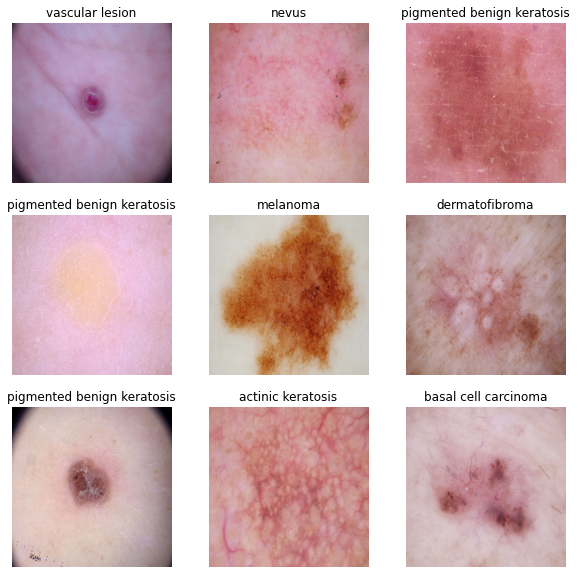

In [ ]:
#using the training data to visualize the single image of all the categories
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Created a CNN model, which can accurately detect 9 classes present in the dataset. Used ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
#creating the model
num_classes = 9 # As target class has 9 labels

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Chosen 'adam' as an optimiser and 'Crossentropy' as loss function for model training 

In [ ]:
#compiling the model with 'adam' as an optimiser and 'Crossentropy' as loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
#training the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 563s 2s/step - loss: 1.9711 - accuracy: 0.2679 - val_loss: 1.8825 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6602 - accuracy: 0.4046 - val_loss: 1.4875 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4896 - accuracy: 0.4743 - val_loss: 1.5502 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3609 - accuracy: 0.5218 - val_loss: 1.4259 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2940 - accuracy: 0.5458 - val_loss: 1.4717 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2253 - accuracy: 0.5575 - val_loss: 1.4770 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1408 - accuracy: 0.5954 - val_loss: 1.4920 - val_accuracy: 0.4944
Epoch 8/20
56

### Visualizing training results

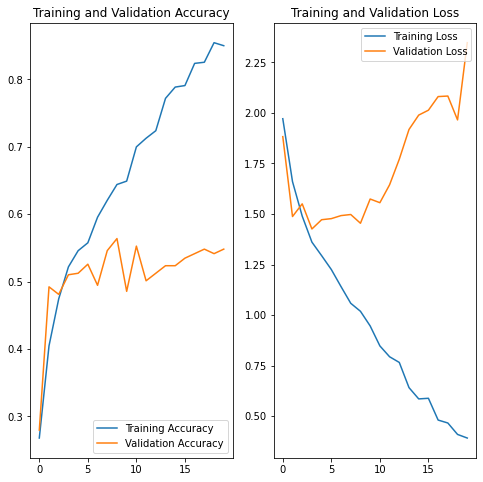

In [ ]:
#code to visualize the training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#code to visualize the accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#code to visualize the loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Below are the findings after the model fit, it shows if there is an evidence of model overfit or underfit

1. We can't consider it as good model as it is not generalized. Training dataset has learnt the noise in the data hence getting good results for training as compared to validation dataset.
2. Training dataset is showing the great results with around 84% accuracy while the validation dataset is decreasing and showing around 56% as its highest accuracy.
3. From the above 2 points, it can be confirmed that the model is overfitting. In the next few segments, we will try to mitigate this issue and build a better generalized model.

In [ ]:
#using horizontal augmentation strategy, this will help to know how it works for one instance of training image

data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

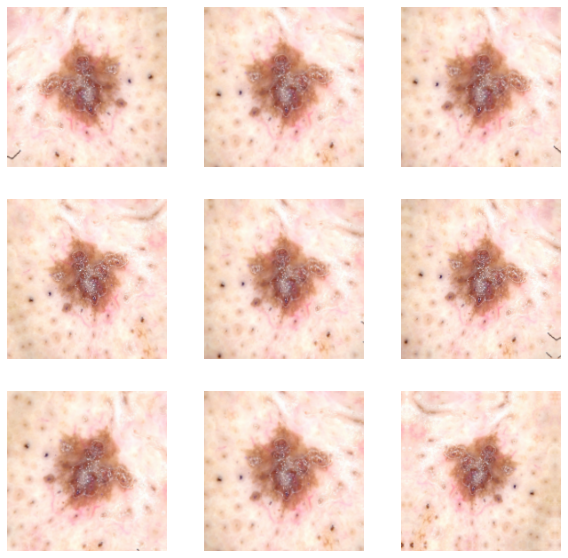

In [ ]:
#visualizing the images to see how augmentation strategy worked for one instance of training images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Creating the model, compile and train the model


In [ ]:
#I have used dropout 0.2 as the model was overfitting.
#creating the model

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [ ]:
#compiling the model with 'adam' as an optimiser and 'Crossentropy' as loss function

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
#training the model with 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 30ms/step - loss: 2.1454 - accuracy: 0.2048 - val_loss: 1.9582 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.8062 - accuracy: 0.3304 - val_loss: 1.7455 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6640 - accuracy: 0.3945 - val_loss: 1.5881 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5319 - accuracy: 0.4548 - val_loss: 1.4359 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4456 - accuracy: 0.4833 - val_loss: 1.5789 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3924 - accuracy: 0.5067 - val_loss: 1.4569 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3477 - accuracy: 0.5184 - val_loss: 1.4482 - val_accuracy: 0.4944
Epoch 8/20
56

### Visualizing the results

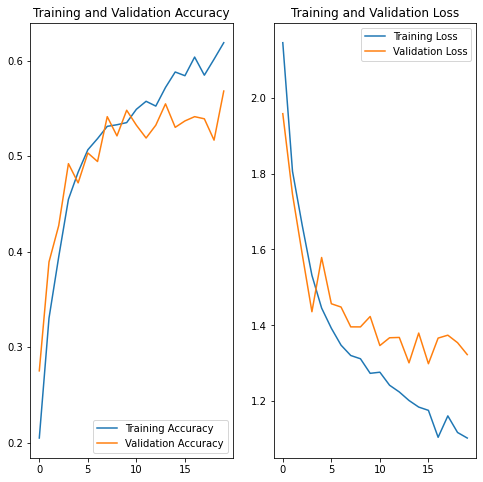

In [ ]:
#code to visualize the training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#code to visualize the accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#code to visualize the loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. We can clearly see that now the training and validation accuracy is close to each other. This shows that augmentation helped in mitigating overfitting in the model. 
2. But we can also observe that the results aren't satisfactory. Accuracy came around 64% for training and 53% for validation. Though both training and validation are close to each other, model is **underfitting** and we need to mitigate that as well.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
#using glob object to identify the number of images in the dataset

from glob import glob
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] 
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print('Total images in the training dataset: ', len(lesion_list))

Total images in the training dataset:  2239


In [ ]:
#taking the image path in a list df_dict_original
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024435.jpg', 'pigmented benign keratosis'), ('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/ISIC_0024445.jpg', 'pigmented benign keratosis')]


In [ ]:
#converting the list to dataframe and displaying top 5 rows from that
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis


In [ ]:
#displaying the number of images in each class
original_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

In [ ]:
#displaying the % of images in each class
original_df[['Label']].value_counts(normalize=True)

Label                     
pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
dtype: float64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


1. From the above results, it is clearly visible that seborrheic keratosis has the least number of samples(77 or 3.4% images).
2. There are 4 top most dominating classes in the dataset which are:
  * pigmented benign keratosis (462 or 20.6% images)
  * melanoma (438 or 19.5% images)
  * basal cell carcinoma (376 or 16.7% images)
  * nevus (357 or 15.9% images)



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#installing augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
#below is the code for augmentor
path_to_training_dataset=str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8DE010EE10>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8D7606A510>: 100%|██████████| 500/500 [00:21<00:00, 23.40 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8D76034C10>: 100%|██████████| 500/500 [00:21<00:00, 22.83 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F8D601C6AD0>: 100%|██████████| 500/500 [01:29<00:00,  5.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F8D760E8850>: 100%|██████████| 500/500 [01:26<00:00,  5.79 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8D601685D0>: 100%|██████████| 500/500 [00:19<00:00, 25.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8D601683D0>: 100%|██████████| 500/500 [00:43<00:00, 11.58 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8D76097590>: 100%|██████████| 500/500 [00:18<00:00, 27.34 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8D76097A10>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
#displaying the number of images after using augmentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print('Total images in the training dataset after using Augmentor: ', image_count_train)

Total images in the training dataset after using Augmentor:  4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
#using glob object to identify the number of images in the dataset
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:2]

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028180.jpg_e4615b37-8dcf-44d8-98e8-d1def1be11e8.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0027367.jpg_abbef40d-643d-4db5-8570-d5584c3b6954.jpg']

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:2]

['pigmented benign keratosis', 'pigmented benign keratosis']

In [ ]:
#taking the image path in a list dataframe_dict_new
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
#converting the list to dataframe
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
#displaying top 5 rows from the dataset
new_df.head()

,Path,Label
0,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
1,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
2,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
3,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis
4,/content/drive/MyDrive/Skin cancer ISIC The In...,pigmented benign keratosis


In [ ]:
#displaying the number of images in each class
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [ ]:
#displaying the % of images in each class to see the distrubution
new_df['Label'].value_counts(normalize=True)

pigmented benign keratosis    0.142751
melanoma                      0.139190
basal cell carcinoma          0.129990
nevus                         0.127170
squamous cell carcinoma       0.101054
vascular lesion               0.094821
actinic keratosis             0.091111
dermatofibroma                0.088292
seborrheic keratosis          0.085621
Name: Label, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
#considering the batch size 32 as more that 32 might need more computational power. height and width needs to be considered as 180
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#used seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
#resized the images to the size img_height*img_width, while writting the dataset
#defining the training data after using augmentor
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
#used seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
#resized the images to the size img_height*img_width, while writting the dataset
#defining the validation data after using augmentor
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
#creating the model

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
#compiling the model with 'adam' as an optimiser and 'Crossentropy' as loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
#training the model with 50 epochs
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 43s 245ms/step - loss: 1.7904 - accuracy: 0.3168 - val_loss: 1.5361 - val_accuracy: 0.4202
Epoch 2/50
169/169 [==============================] - 32s 187ms/step - loss: 1.4855 - accuracy: 0.4332 - val_loss: 1.3929 - val_accuracy: 0.4736
Epoch 3/50
169/169 [==============================] - 30s 171ms/step - loss: 1.3501 - accuracy: 0.4777 - val_loss: 1.4165 - val_accuracy: 0.4588
Epoch 4/50
169/169 [==============================] - 30s 170ms/step - loss: 1.3129 - accuracy: 0.4981 - val_loss: 1.2798 - val_accuracy: 0.4863
Epoch 5/50
169/169 [==============================] - 31s 180ms/step - loss: 1.2329 - accuracy: 0.5291 - val_loss: 1.2841 - val_accuracy: 0.5219
Epoch 6/50
169/169 [==============================] - 30s 170ms/step - loss: 1.1765 - accuracy: 0.5512 - val_loss: 1.1880 - val_accuracy: 0.5278
Epoch 7/50
169/169 [==============================] - 31s 176ms/step - loss: 1.1452 - accuracy: 0.5695 - val_loss: 1.1531 - val_ac

#### **Todo:**  Visualize the model results

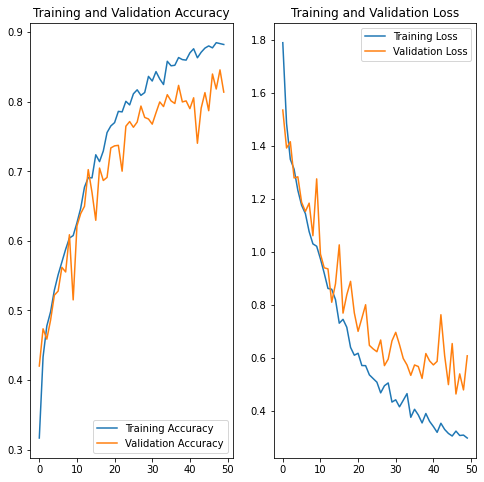

In [ ]:
#code to visualize the training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#code to visualize the accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#code to visualize the loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
1. After adding 500 images of each category, we can clearly see the results have been improved in both training and validation.
2. Undoubtedly, **overfitting** and **underfitting** issue have been resolved in the final model.
3. Adding the images helped in resolving the class imbalance issue for both training and validation dataset.
4. We can also observe that the results are satisfactory now. Accuracy came around 88% for training and 81% for validation.
